In [653]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import math 
%matplotlib inline

In [654]:
def create_kernel_matrix(kernelfunc, size, shift, diag_add):  
    # make matrix diagonally dominant.
    return np.add(np.fromfunction(lambda i, j: kernelfunc(i - shift , j - shift), (size, size)), np.identity(size) * diag_add)  

In [655]:
def create_normal_distribution(kernel): 
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), tf.linalg.inv(kernel)
    scale = tf.linalg.cholesky(cov)
    return tfp.distributions.MultivariateNormalTriL(loc=mu,scale_tril=scale)

In [656]:
def sampleRKHS(kernelfunc, dsize=10, center=True, ssize=12, rkhs_range=(-4,4), func_precision=100, diag_add=1e-5):
    """
    kernelfunc - lambda func that defines the kernel matrix of size dsize x dsize
    dsize - number of elements in the original dataset. 
    ssize - sample size, how many functions from RKHS to sample
    rkhs_range - what range to display the RKHS functions on
    func_precision - how many points to genereate in the rkhs_range (to draw lines) i.e resolution of lines

    returns X, Y -> X: domain values with shape(func_precision, ssize) Y: y values sampled RKHS functions 
    shape(func_precision, ssize) each col represents x and y values of each sampled function. 
    """
    shift = 0
    if center: 
        shift = (dsize // 2) 

    kernel_matrix = create_kernel_matrix(kernelfunc, dsize, shift, diag_add) 
    mvn = create_normal_distribution(kernel_matrix) 
    xi = np.linspace(rkhs_range[0], rkhs_range[1], func_precision) # this will be the domain we will be looking at of the RKHS space. 

    # create a matrix that will store the domains of the sampled value (linespace).
    # each column will be the same since we are analyzing them in the same domain.  
    y = np.reshape(xi.T, (xi.shape[0], 1)) # create a transpose of x (since each col will represent the points we are eval at)
    X_f = y
    X_k = y
    for i in range (0, ssize - 1): # range == # of datums in original dataset. 
        X_f = np.concatenate((X_f, y), axis=1)
    
    for i in range(0, dsize - 1): 
        X_k = np.concatenate((X_k, y), axis=1)

    
    # create functions evaluated at the 10 different basis functions 
    # each basis function is a kernel evaluated at each point holding second variable constant. 
    # in this case we are evaluating the second variable at (almost) all possible points (large number of rows representing domain)
    Kx = np.zeros((X_k.shape[0], dsize))


    for i in range(Kx.shape[0]): 
        for j in range(Kx.shape[1]):
            Kx[i, j] = kernelfunc(j - (dsize // 2), X_k[i, j]) # IndexError: index 12 is out of bounds for axis 1 with size 12
    
    
    # now create the weighted functions now representing the actual functions in RKHS. 
    alphas = mvn.sample([ssize]).numpy() # sample the alpha weights by which each kernel function will be weighed. 
    # each fx will need its own alpha. Amount sampled is the amount of sample functions we want to generate. 
    Fx = np.matmul(Kx, alphas.T)
    return X_f, Fx


In [657]:
# Define the Guassian Kernel
t = 0.5
c = .001
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )

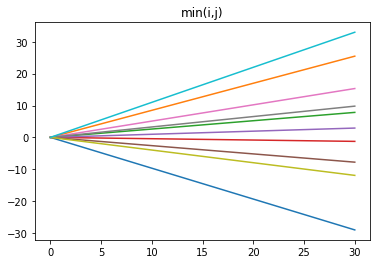

In [709]:
t = 0
#minl = lambda i, j: np.minimum(i, j)
minl = lambda i, j: i * j
x, y = sampleRKHS(minl, dsize=10, center=True, rkhs_range=(0,30))
plt.title('min(i,j)')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig("./figures/m0_01.pdf")


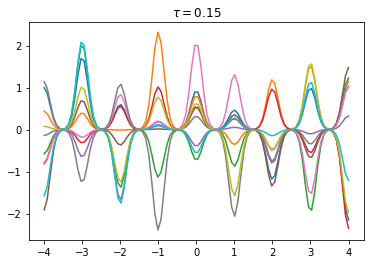

In [659]:
t = 0.15
c = 1
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
x, y = sampleRKHS(gausskernel)

plt.title(r'$\tau = 0.15$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig('./figures/gausst0_15.pdf')

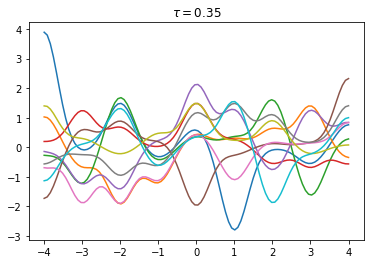

In [660]:
t = .35
c = 1
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
x, y = sampleRKHS(gausskernel)
plt.title(r'$\tau = 0.35$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig('./figures/gausst0_35.pdf')

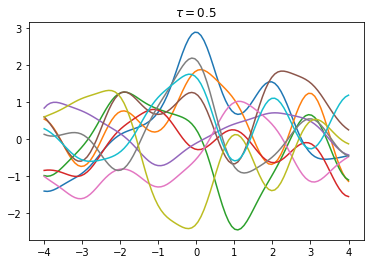

In [661]:
t = .5
c = 1
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
x, y = sampleRKHS(gausskernel)
plt.title(r'$\tau = 0.5$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig('./figures/gausst0_5.pdf')

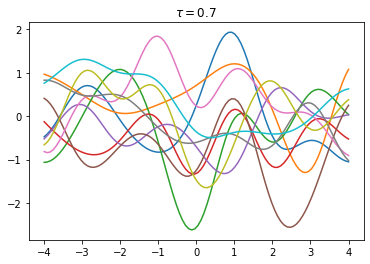

In [662]:
t = .7
c = 1
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
x, y = sampleRKHS(gausskernel)
plt.title(r'$\tau = 0.7$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig('./figures/gausst0_7.pdf')

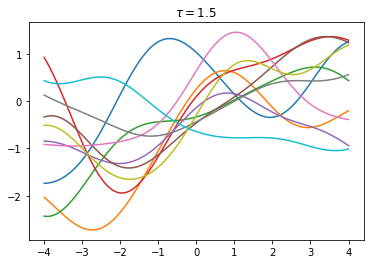

In [663]:
t = 1.5
c = 1
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
x, y = sampleRKHS(gausskernel)
plt.title(r'$\tau = 1.5$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig('./figures/gausst1_5.pdf')

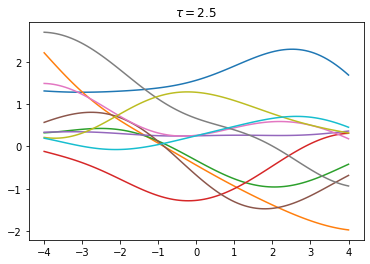

In [664]:
t = 2.5
c = 1
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
x, y = sampleRKHS(gausskernel)
plt.title(r'$\tau = 2.5$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig('./figures/gausst2_5.pdf')

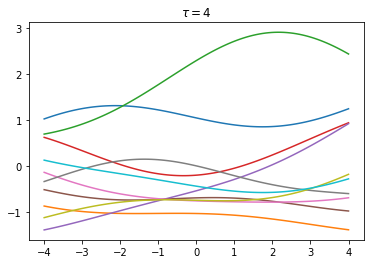

In [665]:
t = 4
c = 1
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
x, y = sampleRKHS(gausskernel)
plt.title(r'$\tau = 4$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig('./figures/gausst4.pdf')

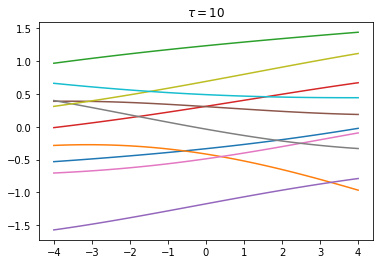

In [712]:
t = 10
c = 1
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
x, y = sampleRKHS(gausskernel)
plt.title(r'$\tau = 10$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig('./figures/gausst10.pdf')

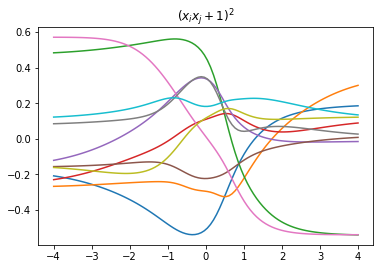

In [745]:
polykernel = lambda i, j: np.power(i, 2)
x2, y2 = sampleRKHS(polykernel, rkhs_range=(-30, 30))
plt.title(r'$(x_i x_j + 1)^2$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig('./figures/polyd2.pdf')

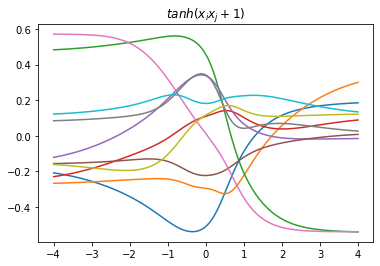

In [744]:
a = 10
b = 0.01

tanh = lambda i, j: np.tanh(i * j * 0.5 + 1)
x, y = sampleRKHS(tanh, rkhs_range=(-4, 4), diag_add=100)
plt.title(r'$tanh(x_i x_j + 1)$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig("./figures/tanh.pdf")


In [729]:
#plt.savefig("./figures/tanh.pdf")

In [0]:
mahalanobis = lambda i, j: np.exp(-0.5 * (i - j) * 0.0002 * (i - j))
x, y = sampleRKHS(mahalanobis, rkhs_range=(-20, 20))
plt.title(r'$e^{\frac{-1}{2}(x_i-x_j)s(x_i-x_j)}, s = 0.00001$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig("./figures/m0_0002.pdf")

In [0]:
mahalanobis = lambda i, j: np.exp(-0.5 * (i - j) * 0.01 * (i - j))
x, y = sampleRKHS(mahalanobis, rkhs_range=(-20, 20))
plt.title(r'$e^{\frac{-1}{2}(x_i-x_j)s(x_i-x_j)}, s = 0.01$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig("./figures/m0_01.pdf")

In [0]:
min = lambda i, j: np.minimum(i, j)
#x, y = sampleRKHS(min, dsize=100, rkhs_range=(-20, 20))
plt.title(r'$e^{\frac{-1}{2}(x_i-x_j)s(x_i-x_j)}, s = 0.01$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig("./figures/m0_01.pdf")